In [126]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below

def fetchForecast(latitude = 52.52, longitude = 13.41, past_days = 92, forecast_days = 1):
	url = "https://previous-runs-api.open-meteo.com/v1/forecast"
	params = {
		"latitude": latitude,
		"longitude": longitude,
		"past_days": past_days,
		"forecast_days": forecast_days,
		"hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "wind_speed_10m"],
		# "models": "ecmwf_ifs04"
	}
	responses = openmeteo.weather_api(url, params=params)

	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]
	print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
	print(f"Elevation {response.Elevation()} m asl")
	print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
	print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

	# Process hourly data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
	hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
	hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
	hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
	hourly_wind_speed_10m = hourly.Variables(4).ValuesAsNumpy()

	hourly_data_forecast = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	hourly_data_forecast["temperature_2m"] = hourly_temperature_2m
	hourly_data_forecast["relative_humidity_2m"] = hourly_relative_humidity_2m
	hourly_data_forecast["apparent_temperature"] = hourly_apparent_temperature
	hourly_data_forecast["precipitation"] = hourly_precipitation
	hourly_data_forecast["wind_speed_10m"] = hourly_wind_speed_10m

	hourly_forecaast_dataframe = pd.DataFrame(data = hourly_data_forecast)
	return hourly_forecaast_dataframe

def fetchArchive(latitude = 52.52, longitude = 13.41, start_date = "2024-03-10", end_date = "2024-06-10"):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": latitude,
		"longitude": longitude,
		"start_date": start_date,
		"end_date": end_date,
		"hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "wind_speed_10m"]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
	print(f"Elevation {response.Elevation()} m asl")
	print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
	print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
	hourly = response.Hourly()
	hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
	hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
	hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
	hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
	hourly_wind_speed_10m = hourly.Variables(4).ValuesAsNumpy()
	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	hourly_data["temperature_2m"] = hourly_temperature_2m
	hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
	hourly_data["apparent_temperature"] = hourly_apparent_temperature
	hourly_data["precipitation"] = hourly_precipitation
	hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

	hourly_dataframe = pd.DataFrame(data = hourly_data)
	return hourly_dataframe

In [127]:
from datetime import datetime, timedelta
x = 14
date_x_days_ago = datetime.now() - timedelta(days=x)
formatted_date = date_x_days_ago.strftime('%Y-%m-%d')

forecast = fetchForecast(past_days=x)
archive = fetchArchive(start_date=formatted_date)
diff = forecast.drop(columns=["date"]) - archive.drop(columns=["date"])
diff = diff.abs()
diff["date"] = forecast["date"]

Coordinates 52.52000045776367°N 13.419998168945312°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 52.5483283996582°N 13.407821655273438°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = diff["date"]
s = diff["temperature_2m"]
#s = diff["apparent_temperature"]

fig, ax = plt.subplots()
ax.plot(t, s)

# ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#        title='About as simple as it gets, folks')
ax.grid()
plt.show()


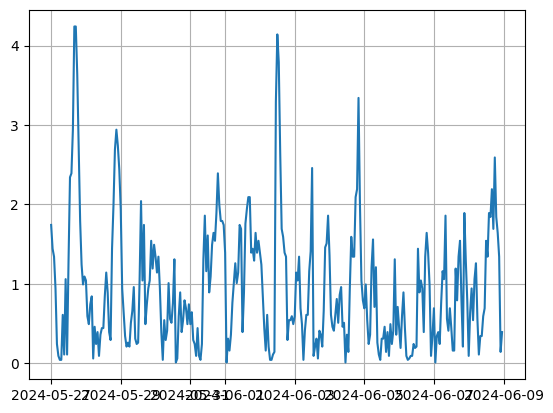

In [128]:
import matplotlib.pyplot as plt
import numpy as np


def plotTemperature(df, dateColumn = "date", tempColumn = "temperature_2m"):
    t = df[dateColumn]
    s = df[tempColumn]
    fig, ax = plt.subplots()
    ax.plot(t, s)
    ax.grid()
    plt.show()

plotTemperature(diff)

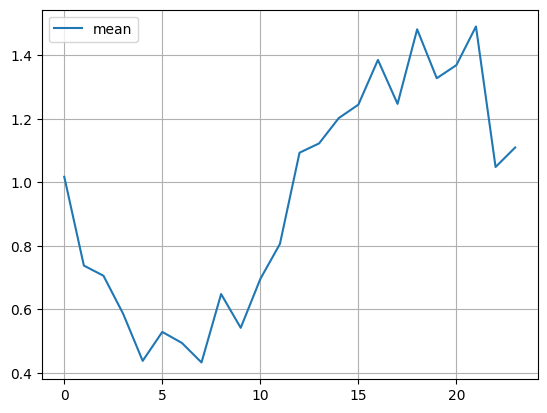

In [ ]:
import matplotlib.pyplot as plt

def plotDifByHour(column = "temperature_2m"):
    mean_diff = diff.groupby(diff["date"].dt.hour)["temperature_2m"].mean().reset_index()
    fig, ax = plt.subplots()
    ax.plot(mean_diff["date"], mean_diff["temperature_2m"], label="mean")
    ax.grid()
    plt.legend()
    plt.show()

plotDifByHour()
plotDifByHour("apparent_temperature")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

grouped_diff = diff.groupby(diff["date"].dt.hour)
for hour, data in grouped_diff:
    print("Group:", hour)
    n, bins, _ = plt.hist(data["temperature_2m"], bins=8)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

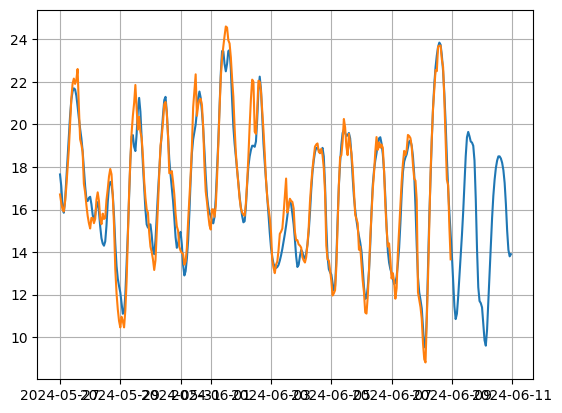

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
#ax.plot(forecast["date"], forecast["temperature_2m"])
#ax.plot(archive["date"], archive["temperature_2m"])

ax.plot(forecast["date"], forecast["precipitation"])
ax.plot(archive["date"], archive["precipitation"])

# ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#        title='About as simple as it gets, folks')
ax.grid()
plt.show()
